In [1]:
"""
This notebook plots the positions of quantity motif calls relative to the TSS.
We mostly use this to identify the locations of activator motifs (Fig. 6B).
"""

'\nThis notebook plots the positions of quantity motif calls relative to the TSS.\nWe mostly use this to identify the locations of activator motifs (Fig. 6B).\n'

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import tqdm

In [3]:
# PRINT COMMANDS TO DOWNLOAD AND EXTRACT DATA

# Set scratch to where you want to download data to
SCRATCH = "/Users/adamhe/github/scratch"

# Extract window coordinates & observed PRO-cap tracks from tfmodisco_results.tar.gz
URL = "https://zenodo.org/records/10597358/files"
TAR = "tfmodisco_results.tar.gz"
print(f"wget {URL}/{TAR} -P {SCRATCH}")
print(f"tar -xvzf {SCRATCH}/{TAR} -C {SCRATCH}")

# Download quantity motif calls
print(f"wget {URL}/quantity_annotated_seqlets_full_cleaned.bed.gz -P {SCRATCH}")

wget https://zenodo.org/records/10597358/files/tfmodisco_results.tar.gz -P /Users/adamhe/github/scratch
tar -xvzf /Users/adamhe/github/scratch/tfmodisco_results.tar.gz -C /Users/adamhe/github/scratch
wget https://zenodo.org/records/10597358/files/quantity_annotated_seqlets_full_cleaned.bed.gz -P /Users/adamhe/github/scratch


In [4]:
# LOAD DATA

# Read in windows around PRO-cap peaks in LCLs
all_bed = pd.read_csv(
    Path(SCRATCH, "tfmodisco_results/merged_windows_all.bed.gz"),
    sep="\t",
    header=None,
    names=["chrom", "start", "end"],
)
# Load the experimental data:
signals = pd.read_csv(
    Path(SCRATCH, "tfmodisco_results/all_tss_windows_procap_mean.csv.gz"),
    header=None,
    index_col=0,
).to_numpy()
signals = signals[:, np.r_[250:750, 1250:1750]]

In [5]:
# Load the motif calls
all_motifs = pd.read_csv(
    Path(SCRATCH, "quantity_annotated_seqlets.bed.gz"),
    sep="\t",
    header=None,
    names=["chrom", "start", "end", "peak_idx", "motif"]
)

# Print motif counts
{
    prefix: len(all_motifs[all_motifs.motif.str.startswith(prefix)])
    for prefix in [motif.split("-")[0] for motif in all_motifs.motif.unique()]
}

{'ETS': 178061,
 'SP/KLF': 148873,
 'NFY': 17793,
 'NRF1': 54866,
 'YY1': 15891,
 'CREB': 20224,
 'CA': 29290,
 'IRF': 37179,
 'CTCF': 20255,
 'TFEC': 9279,
 'THAP': 8725,
 'TBP': 8854,
 'ZBTB33': 7738,
 'POU': 3811,
 'ZNF76': 2696,
 'NFKB2': 2039}

In [6]:
# Get TSS coordinates
tss = signals.argmax(axis=1)
is_mn = tss >= 500
tss_df = pd.DataFrame(
    {
        "tss": tss,
        "is_mn": is_mn,
    }
)
# Subtract 500 from tss if is_mn
tss_df["tss"] = tss_df["tss"].apply(lambda x: x - 500 if x >= 500 else x) + 250

In [7]:
motif_positions = []
for i, hit in tqdm.tqdm(all_motifs.iterrows()):
    peak_idx = hit["peak_idx"]
    tss_coord = tss_df["tss"].iloc[peak_idx] + all_bed.iloc[peak_idx]["start"]
    motif_center = (hit["end"] + hit["start"]) // 2
    tss_strand = tss_df["is_mn"].iloc[peak_idx]
    motif_positions.append(
        tss_coord - motif_center if tss_strand else motif_center - tss_coord
    )

all_motifs["distance_from_tss"] = motif_positions

565574it [00:26, 21330.92it/s]


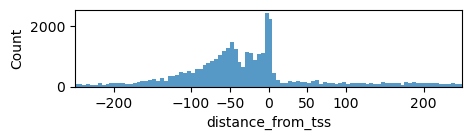

In [13]:
# Get motif positions
motif_name = "IRF"
motif_positions = all_motifs[
    all_motifs.motif.str.startswith(motif_name)
]["distance_from_tss"]

# Set image parameters
xticks = [-200, -100, -50, 0, 50, 100, 200]
plt.rcParams["figure.figsize"] = 5,1
fig, (ax) = plt.subplots(nrows = 1, sharex = True)

# Plot
#sns.kdeplot(motif_positions, bw_adjust=0.5)
sns.histplot(motif_positions, binwidth=5, edgecolor='None')
ax.set_xlim(-250, 250)
ax.set_xticks(xticks)
#plt.savefig(
#    f"img_quantity/{motif_name.replace("/", "")}_hist.pdf",
#    bbox_inches="tight",
#)

<Axes: ylabel='Count'>

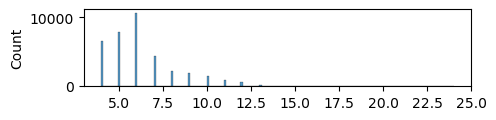

In [19]:
irf = all_motifs[
    all_motifs.motif.str.startswith("IRF")
]
sns.histplot((irf.end - irf.start))

In [20]:
all_motifs[
    (all_motifs.distance_from_tss <= -20) & (all_motifs.distance_from_tss >= -30)
].motif_prefix.value_counts()

AttributeError: 'DataFrame' object has no attribute 'motif_prefix'

In [11]:
all_motifs[
    (all_motifs.distance_from_tss <= +5) & (all_motifs.distance_from_tss >= -5)
].motif.value_counts()

motif
CA-Inr-3    5291
CA-Inr-5    4036
IRF-1       3884
ETS-4       3318
CA-Inr-1    3171
CA-Inr-2    2678
CA-Inr-0    2631
ETS-0       2198
NRF1-0      1773
YY1-0       1454
ETS-1       1430
SP/KLF-1    1295
CTCF-1      1274
ETS-3        944
SP/KLF-0     938
IRF          633
CREB-1       628
CTCF-0       537
TFEC-0       419
NRF1-2       383
ETS-2        359
THAP-1       359
TBP-2        297
ZNF76        281
IRF-3        270
TBP-3        243
ZBTB33       239
NRF1-1       235
THAP-2       228
TBP-1        220
NFY          218
POU          203
CREB         192
TFEC-1       114
SP/KLF       112
YY1-1         83
IRF-4         64
CA-Inr-4      55
TBP-0         54
THAP-0        31
ZNF76-0       24
NFKB2         24
Name: count, dtype: int64